<a href="https://colab.research.google.com/github/nuel071003/MK-Deep-Learning/blob/main/Klasifikasi_Sayuran_Part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Import Necessary Libraries

In [1]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import cv2
from google.colab import drive
import os
import pandas as pd
from PIL import Image, ImageChops, ImageEnhance
import os

2. Load and Transform Data

In [2]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def get_image_df(root_dir):
    IMG_EXT = ('.jpg', '.jpeg', '.png')
    data = []

    for label in os.listdir(root_dir):
        class_dir = os.path.join(root_dir, label)
        if os.path.isdir(class_dir):
            for fname in os.listdir(class_dir):
                if fname.lower().endswith(IMG_EXT):
                    full_path = os.path.join(class_dir, fname)

                    # Buat relative path dari MyDrive
                    if '/content/drive/MyDrive/' in full_path:
                        relative_path = full_path.split('/content/drive/MyDrive/')[-1]

                        # Buat link Drive (bukan direct download, tapi untuk preview)
                        drive_link = f"https://drive.google.com/drive/folders/{'/'.join(relative_path.split('/')[:-1])}"
                    else:
                        drive_link = "Unavailable"

                    data.append({
                        'Filepath': full_path,
                        'Label': label,
                        'Drive_Link': drive_link
                    })

    return pd.DataFrame(data)

image_df = get_image_df('/content/drive/MyDrive/Tugas2DPL')

3. Placing Data into a Dataframe

In [4]:
image_df = image_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(image_df.head())

                                            Filepath   Label  \
0  /content/drive/MyDrive/Tugas2DPL/Terong/eggpla...  Terong   
1  /content/drive/MyDrive/Tugas2DPL/Bayam/aug_0_2...   Bayam   
2  /content/drive/MyDrive/Tugas2DPL/Terong/ELA_au...  Terong   
3  /content/drive/MyDrive/Tugas2DPL/Bayam/ELA_aug...   Bayam   
4  /content/drive/MyDrive/Tugas2DPL/Terong/eggpla...  Terong   

                                          Drive_Link  
0  https://drive.google.com/drive/folders/Tugas2D...  
1  https://drive.google.com/drive/folders/Tugas2D...  
2  https://drive.google.com/drive/folders/Tugas2D...  
3  https://drive.google.com/drive/folders/Tugas2D...  
4  https://drive.google.com/drive/folders/Tugas2D...  


4. Visualizing images from the dataset

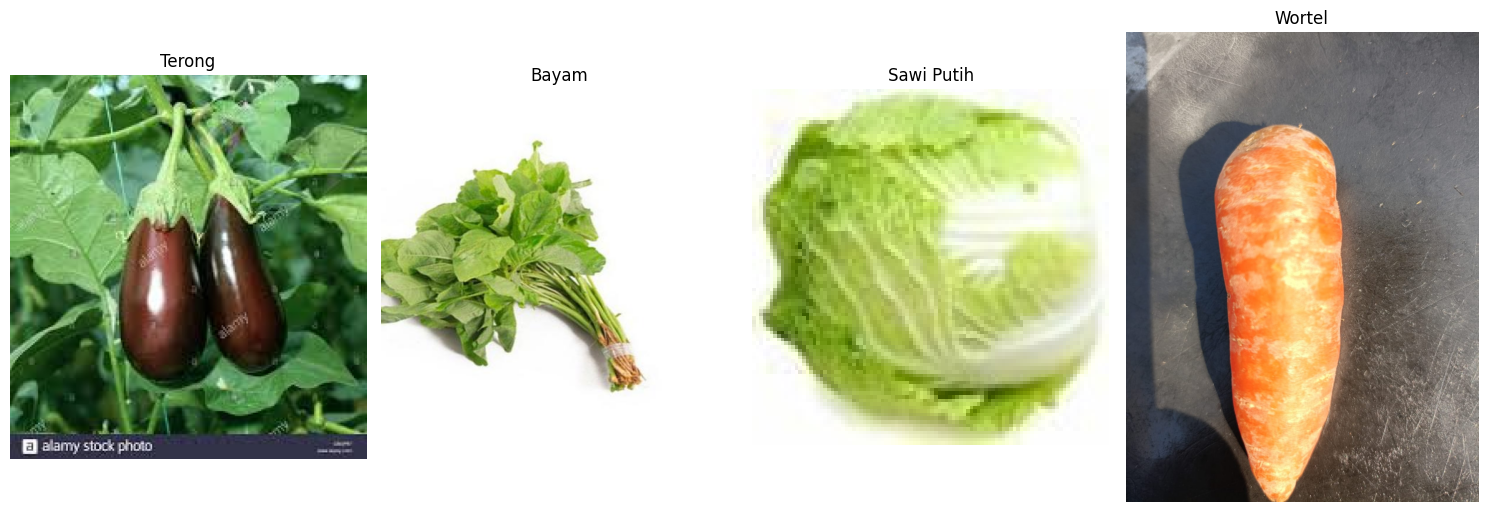

In [5]:
unique_labels = image_df['Label'].unique()
fig, axes = plt.subplots(1, len(unique_labels), figsize=(15, 5))
for idx, label in enumerate(unique_labels):
    img_path = image_df[image_df['Label'] == label].iloc[0]['Filepath']
    img = Image.open(img_path)
    axes[idx].imshow(img)
    axes[idx].set_title(label)
    axes[idx].axis('off')
plt.tight_layout()
plt.show()

5. Computing Error Rate Analysis

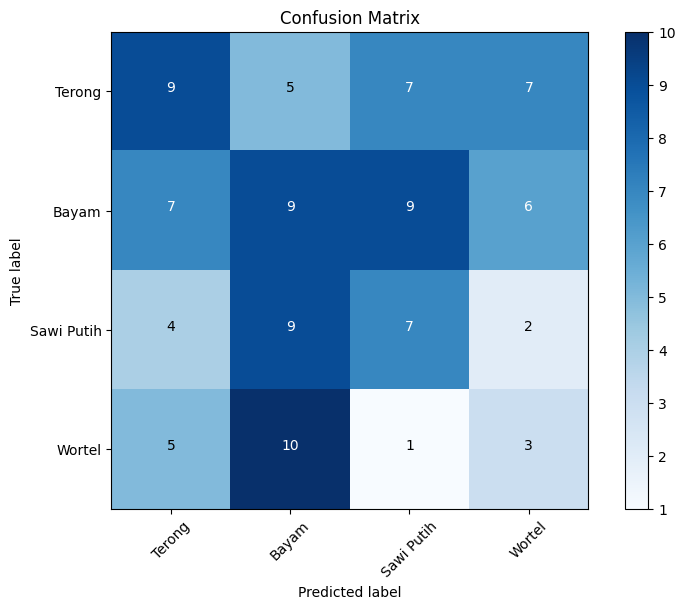

              precision    recall  f1-score   support

      Terong       0.36      0.32      0.34        28
       Bayam       0.27      0.29      0.28        31
  Sawi Putih       0.29      0.32      0.30        22
      Wortel       0.17      0.16      0.16        19

    accuracy                           0.28       100
   macro avg       0.27      0.27      0.27       100
weighted avg       0.28      0.28      0.28       100

Error Rate: 0.72


In [6]:
y_true = np.random.randint(0, len(unique_labels), 100)
y_pred = np.random.randint(0, len(unique_labels), 100)

from sklearn.metrics import confusion_matrix, classification_report

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(unique_labels))
plt.xticks(tick_marks, unique_labels, rotation=45)
plt.yticks(tick_marks, unique_labels)

thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


# Define input_root before using it.
# This is a placeholder, replace '/path/to/your/input' with the actual path.
input_root = '/path/to/your/input'
output_root = input_root  # Output same as input
ela_quality = 80

# Classification Report
print(classification_report(y_true, y_pred, target_names=unique_labels))

# Calculate error rate
error_rate = np.mean(y_true != y_pred)
print(f"Error Rate: {error_rate}")

6. Data Preprocessing

In [7]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a consistent size
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize image data
])

# Create a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['Filepath']
        image = Image.open(img_path).convert('RGB')  # Ensure images are in RGB format
        label = self.df.iloc[idx]['Label']

        if self.transform:
            image = self.transform(image)

        return image, label


In [8]:
# Split data into training and validation sets
train_df, val_df = train_test_split(image_df, test_size=0.2, random_state=42, stratify=image_df['Label'])

# Create datasets and dataloaders
train_dataset = CustomDataset(train_df, transform=transform)
val_dataset = CustomDataset(val_df, transform=transform)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [9]:
train_df, temp_df = train_test_split(image_df, test_size=0.3, random_state=42, stratify=image_df['Label'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['Label'])


print(f"Training data size: {len(train_df)}")
print(f"Validation data size: {len(val_df)}")
print(f"Testing data size: {len(test_df)}")

# Create datasets and dataloaders
train_dataset = CustomDataset(train_df, transform=transform)
val_dataset = CustomDataset(val_df, transform=transform)
test_dataset = CustomDataset(test_df, transform=transform)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Training data size: 1255
Validation data size: 269
Testing data size: 270


7. Training the model

In [17]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import LearningRateScheduler

In [13]:
# MobileNetV2 Base Model
mobilenet_base = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

In [18]:
# Fine-tune semua layer (bisa di-freeze jika ingin lebih cepat)
mobilenet_base.trainable = False  # Ubah ke False jika ingin frozen base

# Custom model head
inputs = Input(shape=(224, 224, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
x = mobilenet_base(x)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dropout(0.5)(x)  # Tambahkan dropout setelah dense layer

# Mendapatkan jumlah kelas dari image_df
num_classes = image_df['Label'].nunique()
outputs = Dense(num_classes, activation='softmax')(x)

# Bangun model
model = Model(inputs, outputs)

# Compile
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
callbacks = [
    ModelCheckpoint("mobilenetv2_best.weights.h5", save_best_only=True, monitor="val_accuracy", save_weights_only=True),
    EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.2, verbose=1),
    TensorBoard(log_dir="logs")
]

# Build model secara eksplisit
_ = model(inputs)
model.summary()

optimizer = Adam(learning_rate=5e-5)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,456,004 (9.37 MB)

 Trainable params: 198,020 (773.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [15]:
# Custom head
num_classes = len(image_df['Label'].unique()) # Define num_classes based on unique labels in your dataset

# Compile the model before training
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
def extract_data_from_loader(loader):
  """Extract data and labels from a PyTorch DataLoader."""
  images, labels = [], []
  for batch_images, batch_labels in loader:
    # Permute the dimensions to match TensorFlow's expected input shape
    images.extend(batch_images.permute(0, 2, 3, 1).numpy())
    labels.extend(batch_labels)
  return np.array(images), np.array(labels)

# Extract data and labels
train_images, train_labels = extract_data_from_loader(train_loader)
val_images, val_labels = extract_data_from_loader(val_loader)

# Create a label mapping (string label to integer)
label_mapping = {label: i for i, label in enumerate(image_df['Label'].unique())}

# Convert string labels to numerical labels using the mapping
train_labels_numerical = np.array([label_mapping[label] for label in train_labels])
val_labels_numerical = np.array([label_mapping[label] for label in val_labels])

def extract_data_from_loader(loader):
  """Extract data and labels from a PyTorch DataLoader."""
  images, labels = [], []
  for batch_images, batch_labels in loader:
    # Permute the dimensions to match TensorFlow's expected input shape
    images.extend(batch_images.permute(0, 2, 3, 1).numpy())
    labels.extend(batch_labels)
  return np.array(images), np.array(labels)

# Extract data and labels
train_images, train_labels = extract_data_from_loader(train_loader)
val_images, val_labels = extract_data_from_loader(val_loader)

# Create a label mapping (string label to integer)
label_mapping = {label: i for i, label in enumerate(image_df['Label'].unique())}

# Convert string labels to numerical labels using the mapping
train_labels_numerical = np.array([label_mapping[label] for label in train_labels])
val_labels_numerical = np.array([label_mapping[label] for label in val_labels])

# Now use to_categorical with the numerical labels
train_labels = to_categorical(train_labels_numerical, num_classes=num_classes)
val_labels = to_categorical(val_labels_numerical, num_classes=num_classes)

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 72s 3s/step - accuracy: 0.2553 - loss: 1.8062 - val_accuracy: 0.3271 - val_loss: 1.3119 - learning_rate: 1.0000e-04
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 101s 4s/step - accuracy: 0.2815 - loss: 1.5472 - val_accuracy: 0.3569 - val_loss: 1.2817 - learning_rate: 1.0000e-04
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 123s 3s/step - accuracy: 0.3146 - loss: 1.3998 - val_accuracy: 0.3197 - val_loss: 1.2610 - learning_rate: 1.0000e-04
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 91s 4s/step - accuracy: 0.3380 - loss: 1.3297 - val_accuracy: 0.3457 - val_loss: 1.2369 - learning_rate: 1.0000e-04
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 73s 4s/step - accuracy: 0.3844 - loss: 1.2680 - val_accuracy: 0.3643 - val_loss: 1.2021 - learning_rate: 1.0000e-04
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 82s 4s/step - accuracy: 0.4048 - loss: 1.2353 - val_accuracy: 0.5539 - val_loss: 1.1665 - learning_rate: 1.0000e-04
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 72s 3s/step - accuracy: 0.4457 - los

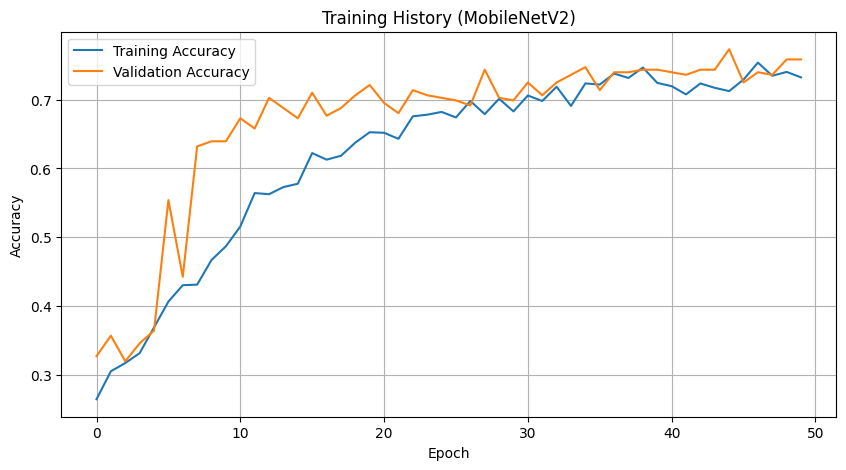

In [19]:
# Train
history = model.fit(
    train_images,
    train_labels,
    validation_data=(val_images, val_labels),
    epochs=50,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training History (MobileNetV2)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

8. Model Evaluation

In [22]:
# ... (Previous code) ...

# Extract data and labels for the test set using the previously defined extract_data_from_loader function
test_images, test_labels = extract_data_from_loader(test_loader)

# Create a label mapping (string label to integer) - this is assuming you haven't already defined this mapping earlier
label_mapping = {label: i for i, label in enumerate(image_df['Label'].unique())}

# Convert string labels to numerical labels using the mapping
test_labels_numerical = np.array([label_mapping[label] for label in test_labels])

# Now use to_categorical with the numerical labels
test_labels = to_categorical(test_labels_numerical, num_classes=num_classes)

# ... (Rest of the code) ...

# In the evaluation section, you can now use test_images and test_labels:
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"\nEvaluasi Model:\n- Loss: {test_loss:.4f}\n- Akurasi: {test_accuracy:.4%}")

# ... (Remaining code) ...

9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7227 - loss: 0.4548

Evaluasi Model:
- Loss: 0.4499
- Akurasi: 75.1852%


In [23]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# Predict class probabilities
y_pred_probs = model.predict(val_images)
# Convert one-hot to class labels
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(val_labels, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.44      0.55        88
           1       0.61      0.84      0.71        90
           2       0.98      0.98      0.98        46
           3       1.00      0.98      0.99        45

    accuracy                           0.76       269
   macro avg       0.83      0.81      0.81       269
weighted avg       0.77      0.76      0.75       269



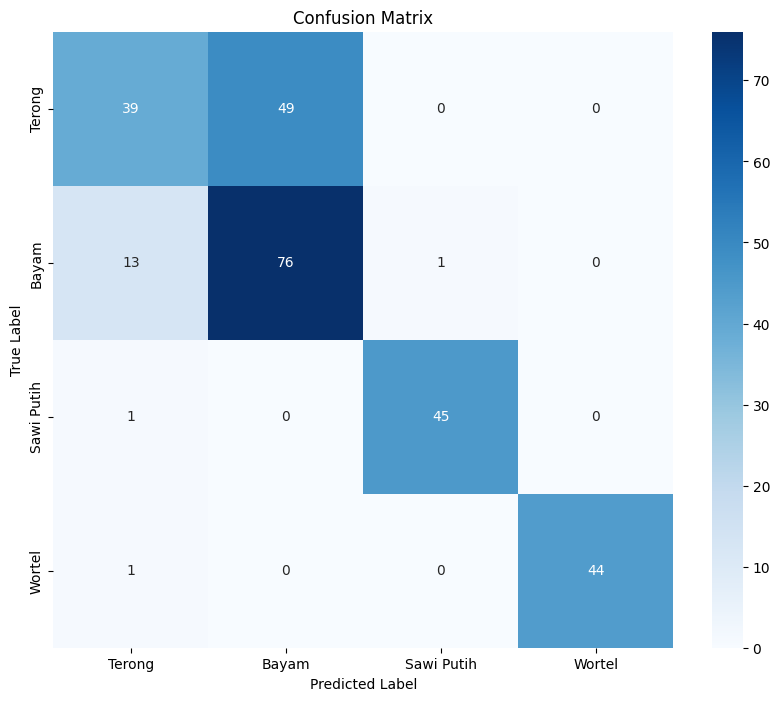

In [24]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=list(label_mapping.keys()),
            yticklabels=list(label_mapping.keys()))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

9. Visualizing loss curves

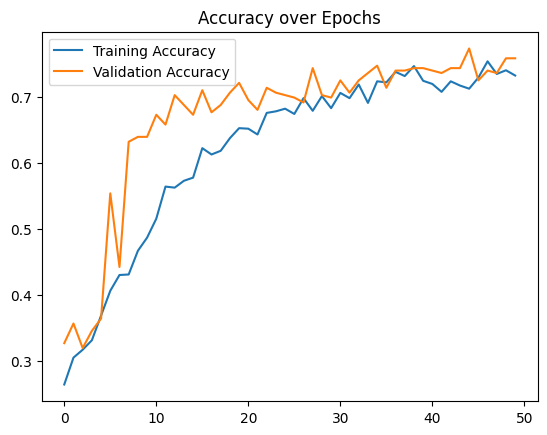

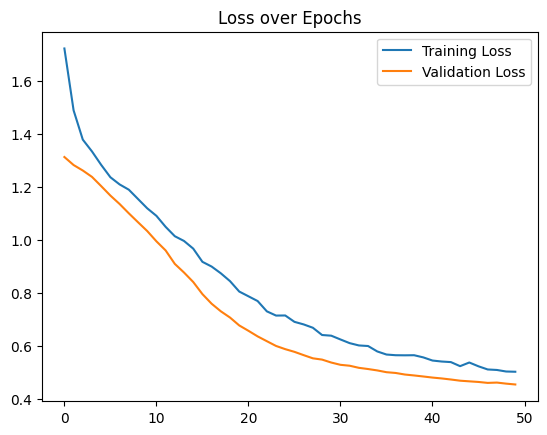

In [25]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Accuracy over Epochs")
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Loss over Epochs")
plt.show()

10. Making Predictions on the Test Data

9/9 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step


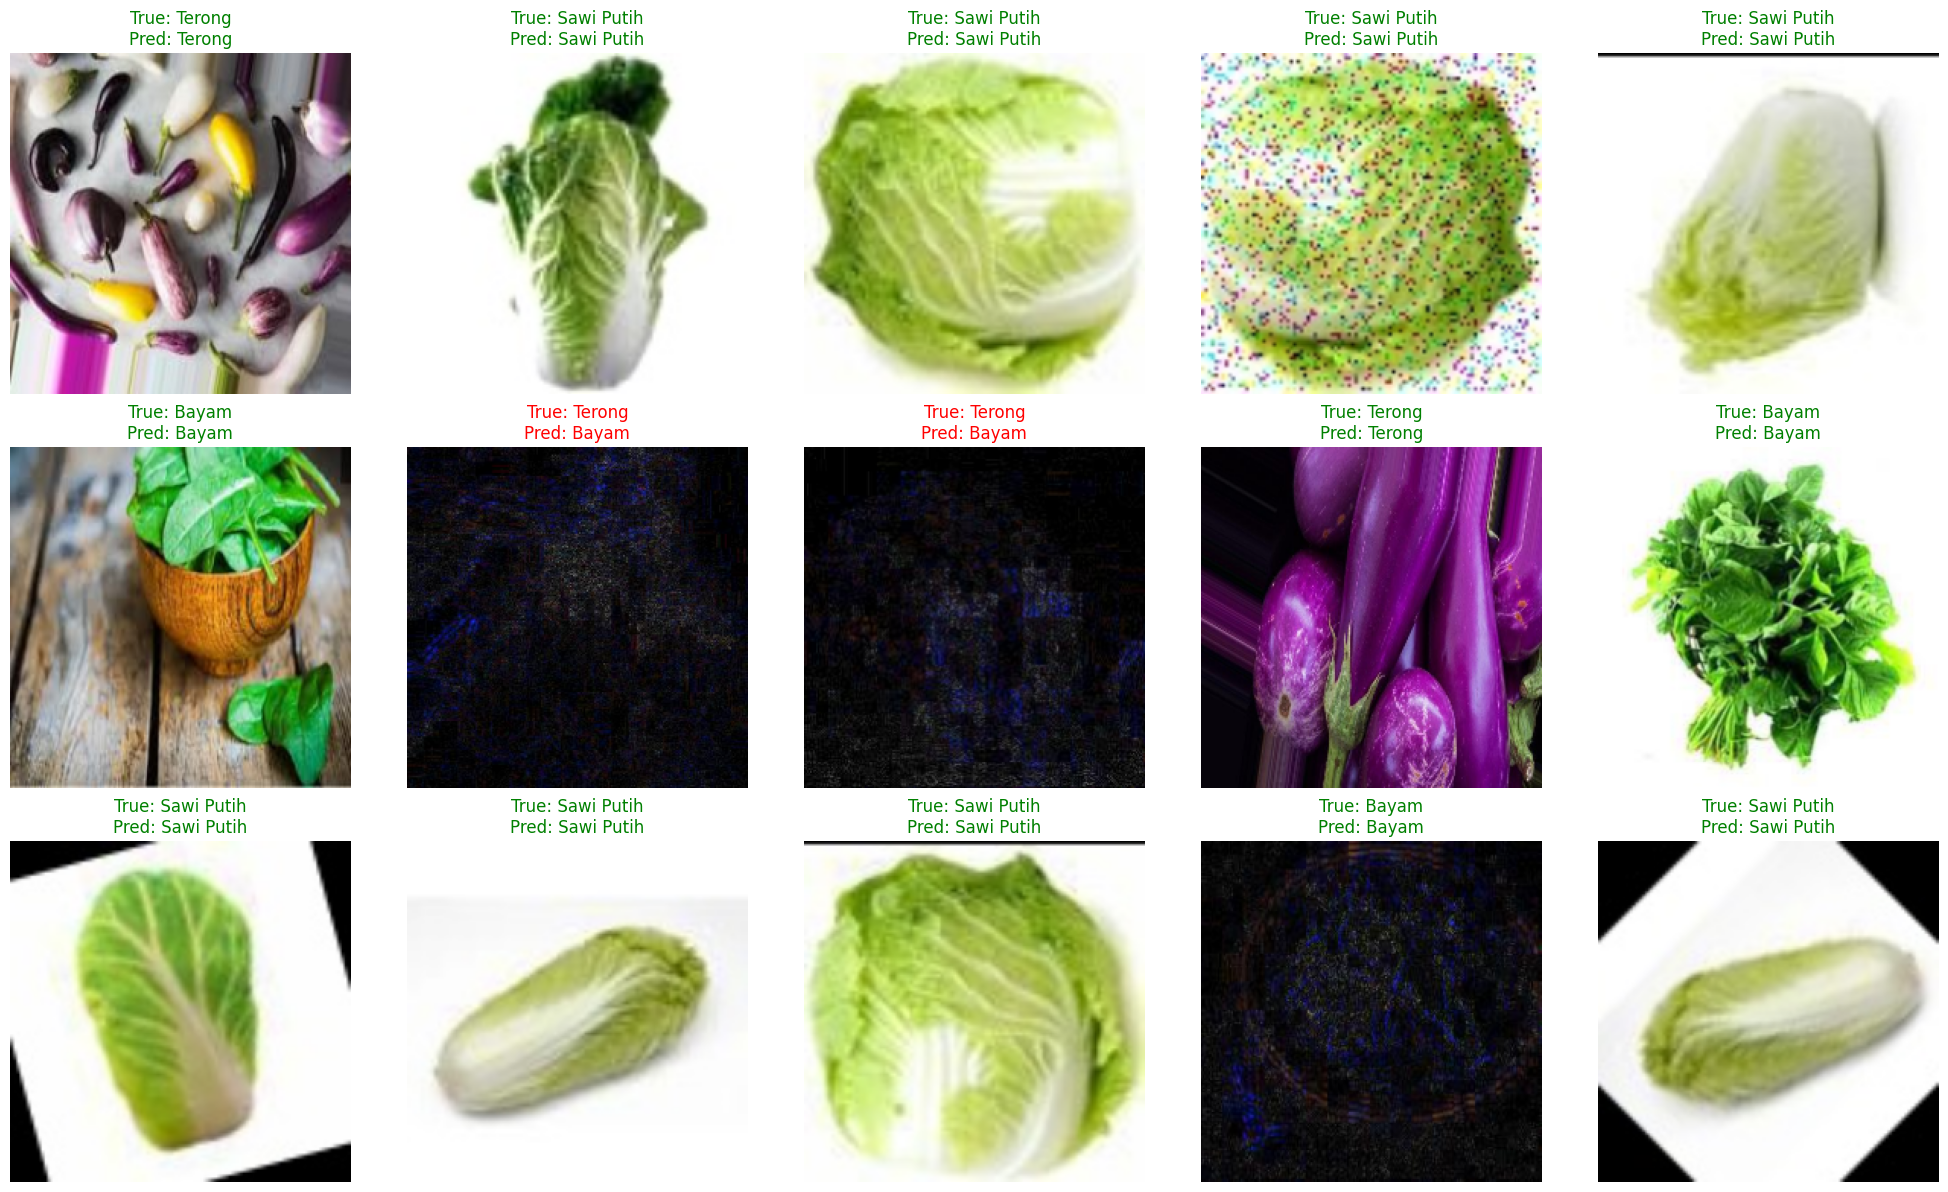

In [29]:
preds = model.predict(test_images)
pred_labels = np.argmax(preds, axis=1)

# Instead of using train_images, derive label_map from the original image_df DataFrame
label_map = {i: label for i, label in enumerate(image_df['Label'].unique())}

pred_names = [label_map[i] for i in pred_labels]

# Define TARGET_SIZE here
TARGET_SIZE = (224, 224) # Example size, adjust as needed

idx = np.random.randint(0, len(test_df), 15)
fig, axes = plt.subplots(3, 5, figsize=(20, 12))
for ax, i in zip(axes.flat, idx):
    img = plt.imread(test_df.iloc[i]['Filepath'])
    # Assuming TARGET_SIZE is defined elsewhere in your code
    img = cv2.resize(img, TARGET_SIZE)
    ax.imshow(img)
    true = test_df.iloc[i]['Label']
    pred = pred_names[i]
    ax.set_title(f"True: {true}\nPred: {pred}", color="green" if true == pred else "red")
    ax.axis('off')
plt.tight_layout()
plt.show()

11. Grad-CAM Visualization

In [30]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name='Conv_1', pred_index=None):

    # Build a model that maps the input image to the activations and predictions
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Compute the gradient of the top predicted class
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Gradients of class output w.r.t. conv layer
    grads = tape.gradient(class_channel, conv_outputs)

    # Mean intensity of gradient over feature map
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    # Weight the convolution outputs by the pooled gradients
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap + 1e-10)
    return heatmap.numpy()


In [35]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name='mobilenetv2_1.00_224', pred_index=None):
    # Build a model that maps the input image to the activations
    # and predictions
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Compute the gradient of the top predicted class
    # for our input image with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 and 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()